<a href="https://colab.research.google.com/github/minhnguyen220104/MineSweeper/blob/main/Skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (**akiec**), basal cell carcinoma (**bcc**), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, **bkl**), dermatofibroma (**df**), melanoma (**mel**), melanocytic nevi (**nv**) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [ ]:
!pip install -q kaggle

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngtminh","key":"2e9aa66256ead50cdbf258d78be73145"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json  ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d farjanakabirsamanta/skin-cancer-dataset

100% 2.57G/2.58G [00:26<00:00, 230MB/s]
100% 2.58G/2.58G [00:26<00:00, 106MB/s]


In [ ]:
!mkdir skin_cancer

In [ ]:
!unzip skin-cancer-dataset.zip -d skin_cancer

Streaming output truncated to the last 5000 lines.
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029321.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029322.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029323.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029324.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029325.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029326.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029327.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029328.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029329.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029330.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029331.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029332.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029333.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029334.jpg

In [ ]:
meta_data = pd.read_csv("/content/skin_cancer/HAM10000_metadata.csv")
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Calculate class counts
class_counts = meta_data['dx'].value_counts()

# Define label dictionary
label_dict = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Calculate class weights
class_weights = {label_dict[key]: (1 / val) * (meta_data.shape[0] / 2.0) for key, val in class_counts.items()}
print(class_weights)

# Check class distribution
class_counts = meta_data['dx'].value_counts()
print(class_counts)

{5: 0.7468307233407905, 4: 4.499101527403415, 2: 4.556414922656961, 1: 9.742217898832685, 0: 15.313455657492355, 6: 35.264084507042256, 3: 43.54347826086956}
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
# Preprocessing (CLEANER CODE :))
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB :)
    img = cv2.resize(img, (image_size, image_size))
    return img

# Load and preprocess images
X = []
y = []
label_dict = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

for index, row in meta_data.iterrows():
    if index % 1000 == 0:
        print(f"Processing image {index}")
    img_id = row['image_id'] + '.jpg'
    img_path = os.path.join('/content/skin_cancer/Skin Cancer/Skin Cancer', img_id)
    if os.path.exists(img_path):
        img = preprocess_image(img_path)
        X.append(img)
        y.append(label_dict[row['dx']])
    else:
        print(f"Image file does not exist: {img_id}")

X = np.array(X, dtype=np.float32) / 255.0
y = to_categorical(np.array(y), num_classes=7)

Processing image 0
Processing image 1000
Processing image 2000
Processing image 3000
Processing image 4000
Processing image 5000
Processing image 6000
Processing image 7000
Processing image 8000
Processing image 9000
Processing image 10000


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Data Augmentation with more parameters :)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [ ]:
# Model Creation with Fine-tuning :)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Increased the number of neurons
x = Dense(128, activation='relu')(x)  # Additional dense layer
output = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# Unfreeze some layers of the base model for fine-tuning :)
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
# Model compilation :)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
# Callbacks :)
# Save Best Model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Adjust Learning Rate during Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
# Train the model with class weights and larger batch size :)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=5,
    class_weight=class_weights,  # Add class weights here
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/5
251/251 [==============================] - ETA: 0s - loss: 5.2711 - accuracy: 0.4566

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 94s 205ms/step - loss: 5.2711 - accuracy: 0.4566 - val_loss: 15.6964 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 2/5
251/251 [==============================] - 48s 192ms/step - loss: 4.5166 - accuracy: 0.5271 - val_loss: 145.9452 - val_accuracy: 0.1128 - lr: 1.0000e-04
Epoch 3/5
251/251 [==============================] - 48s 192ms/step - loss: 4.3317 - accuracy: 0.5613 - val_loss: 102.4426 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 4/5
251/251 [==============================] - 49s 196ms/step - loss: 3.9892 - accuracy: 0.5954 - val_loss: 119.5003 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 5/5
251/251 [==============================] - 53s 210ms/step - loss: 3.8168 - accuracy: 0.5716 - val_loss: 112.3778 - val_accuracy: 0.1128 - lr: 1.0000e-04


In [ ]:
# Predict on test data :)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=label_dict.keys(), output_dict=True)
print(report)

63/63 [==============================] - 3s 36ms/step
{'akiec': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 69}, 'bcc': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 93}, 'bkl': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 228}, 'df': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28}, 'mel': {'precision': 0.11283075386919621, 'recall': 1.0, 'f1-score': 0.2027815163750561, 'support': 226}, 'nv': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1338}, 'vasc': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'accuracy': 0.11283075386919621, 'macro avg': {'precision': 0.016118679124170886, 'recall': 0.14285714285714285, 'f1-score': 0.028968788053579442, 'support': 2003}, 'weighted avg': {'precision': 0.012730779018691135, 'recall': 0.11283075386919621, 'f1-score': 0.022879991363336336, 'support': 2003}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


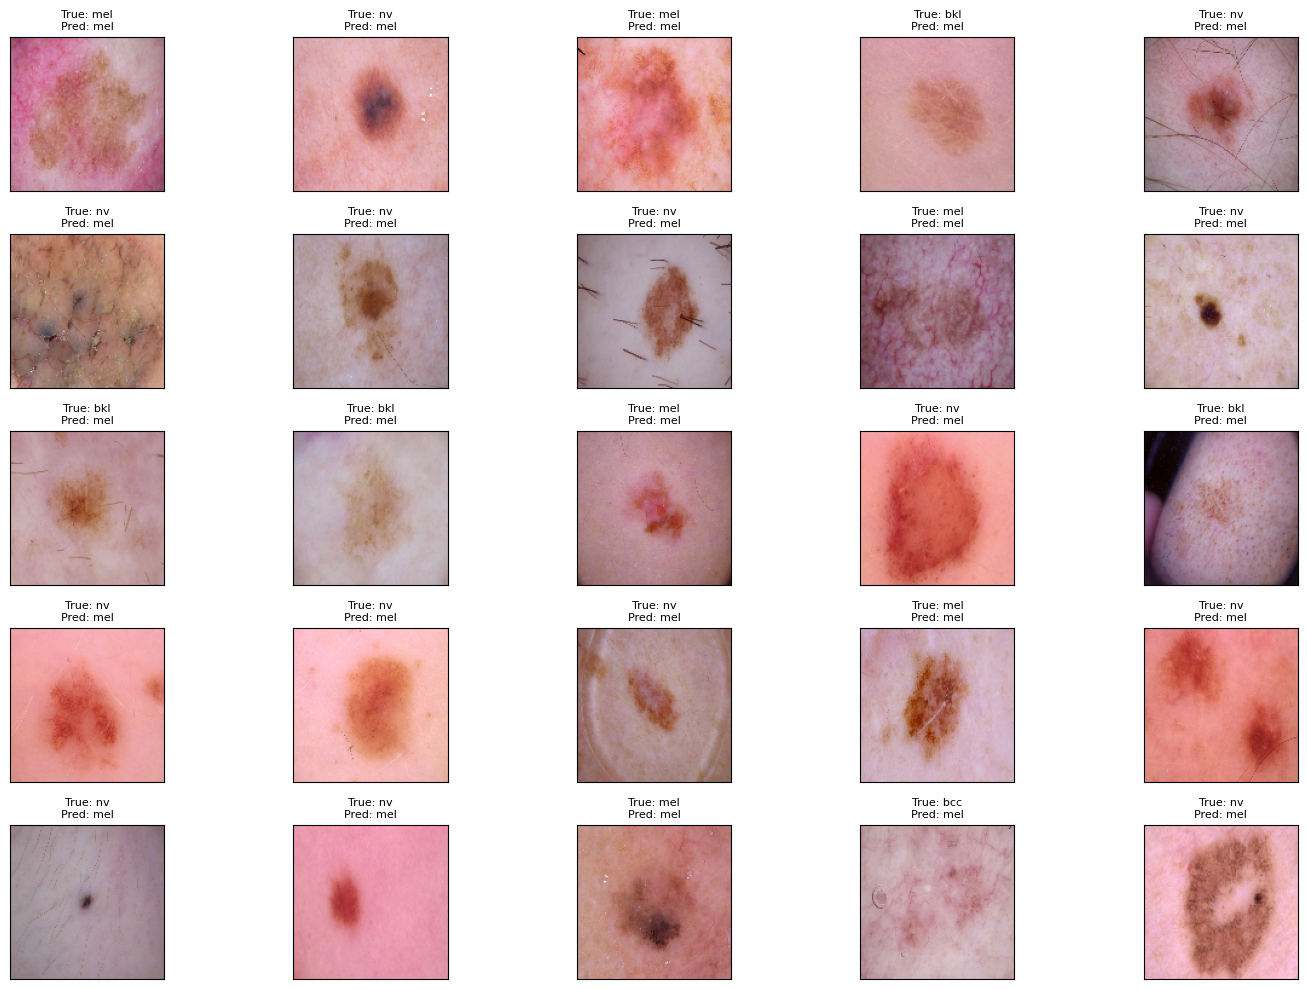

In [ ]:
# Visualizing Predictions :)
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f"True: {list(label_dict.keys())[true_labels[i]]}\nPred: {list(label_dict.keys())[predicted_labels[i]]}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot some test images along with the true and predicted labels
plot_images(X_test[:25], true_classes[:25], predicted_classes[:25])

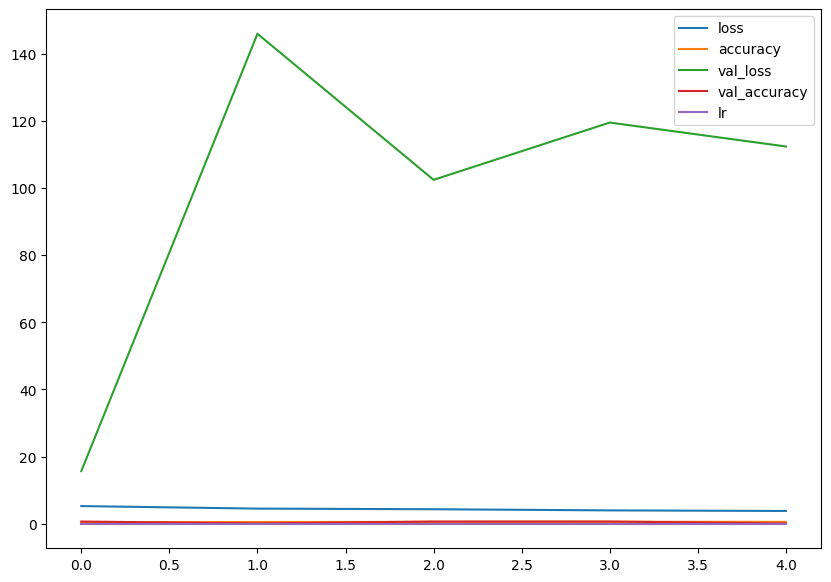

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10, 7));